# Customer Segmentation and Analysis
Steps to solve the problem :

* Exploration of data.
* Data Visualization.
* Check all Hyperparameters for better clustering and good Scores
* Clustering using K-Means and other Clustering Algorithms.
* 2D and 3D Plot of Clusters.
* Silhouette Plot

In [ ]:
import os
import random
import itertools
import warnings
from itertools import product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import plotly as py
import plotly.graph_objs as go
import plotly.express as px

from sklearn.cluster import (
    DBSCAN,
    AffinityPropagation,
    MeanShift,
    MiniBatchKMeans,
    KMeans,
    AgglomerativeClustering,
    estimate_bandwidth,
)
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn import cluster, mixture, metrics
import sklearn

warnings.filterwarnings("ignore")
py.offline.init_notebook_mode(connected = True)

random_seed = 69

np.random.seed(random_seed)
random.seed(random_seed)


# Data

In [2]:
df = pd.read_csv('dataset/Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [4]:
df.dtypes

CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

In [5]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [6]:
df.Gender.unique()

array(['Male', 'Female'], dtype=object)

In [7]:
df['Gender2'] = df['Gender'].map({'Female' : 0 , 'Male' : 1})

In [8]:
df2 = df.drop(['CustomerID' , 'Gender'] , axis = 1)

# Data Visualization

In [9]:
plt.style.use('fivethirtyeight')

## Histogram

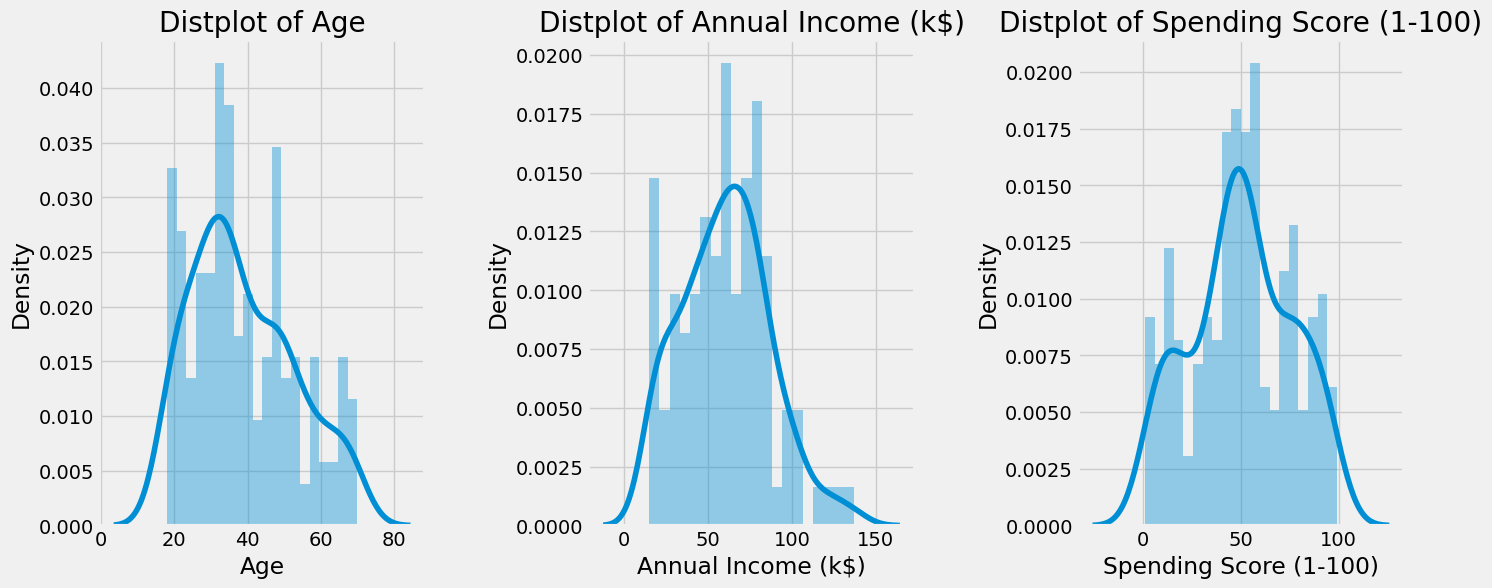

In [10]:
plt.figure(1 , figsize = (15 , 6))
n = 0 
for x in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
    n += 1
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    sns.distplot(df[x] , bins = 20)
    plt.title(f'Distplot of {x}')
plt.show()

## Count Plot of Gender

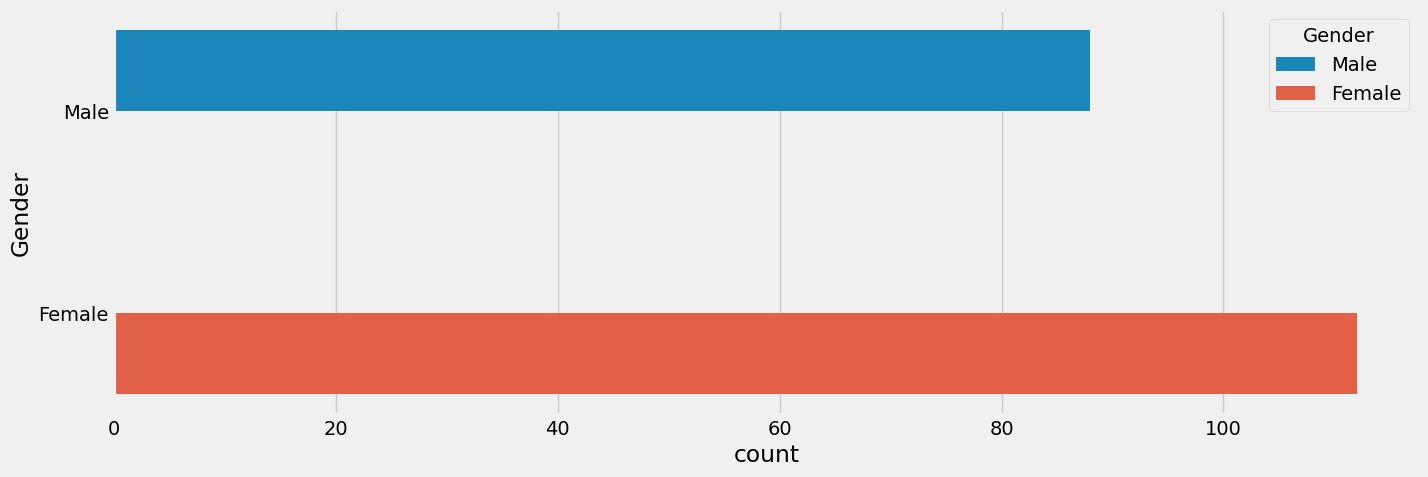

In [11]:
plt.figure(1 , figsize = (15 , 5))
sns.countplot(y = 'Gender' , data = df, hue='Gender')
plt.show()

Ploting the Relation between Age , Annual Income and Spending Score

In [12]:
# hello 

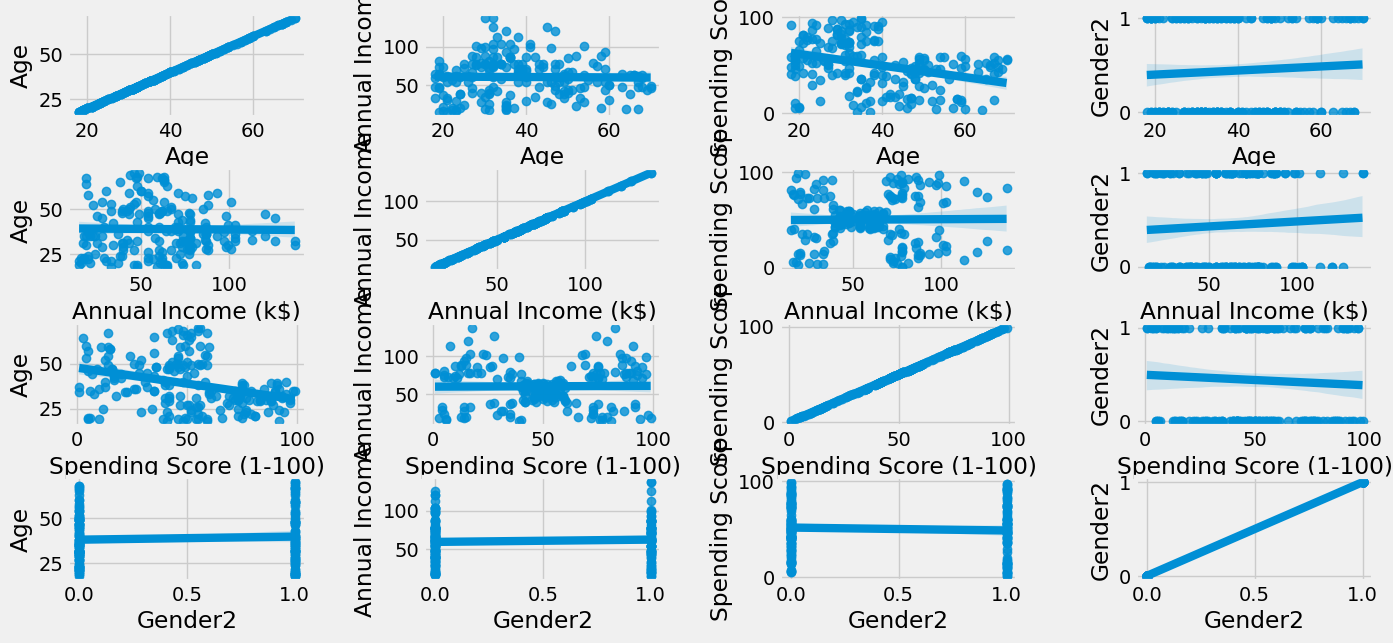

In [13]:
plt.figure(1 , figsize = (15 , 7))
n = 0 
for x in df2.columns:
    for y in df2.columns:
        n += 1
        plt.subplot(len(df2.columns) , len(df2.columns) , n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
        sns.regplot(x = x , y = y , data = df)
        plt.ylabel(y.split()[0]+' '+y.split()[1] if len(y.split()) > 1 else y )
plt.show()

In [14]:
df2.corr()

,Age,Annual Income (k$),Spending Score (1-100),Gender2
Age,1.000000,-0.012398,-0.327227,0.060867
Annual Income (k$),-0.012398,1.000000,0.009903,0.056410
Spending Score (1-100),-0.327227,0.009903,1.000000,-0.058109
Gender2,0.060867,0.056410,-0.058109,1.000000


<Axes: >

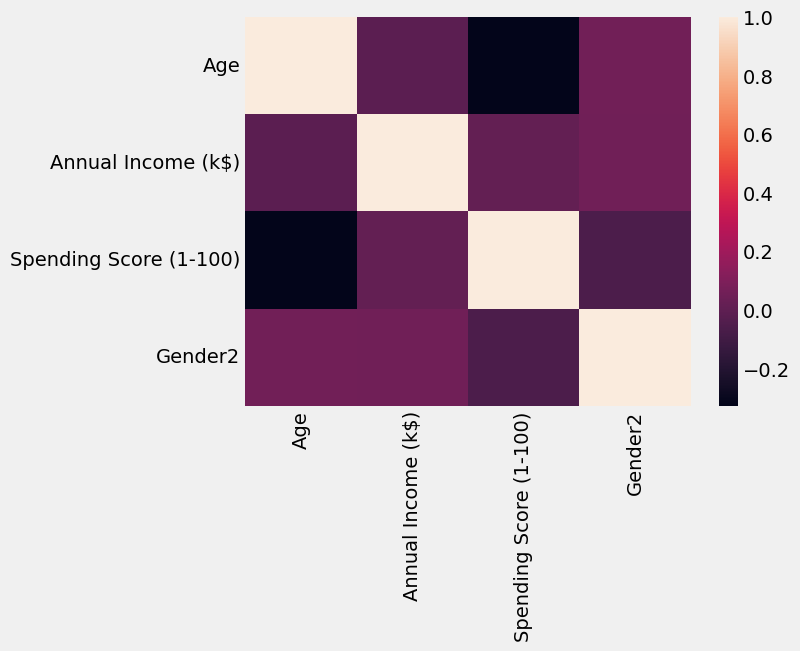

In [15]:
sns.heatmap(df2.corr())

I must say it makes good sense to see negative correlation between Age and Spending Score, People with greater age spend less (wisdom speaks)

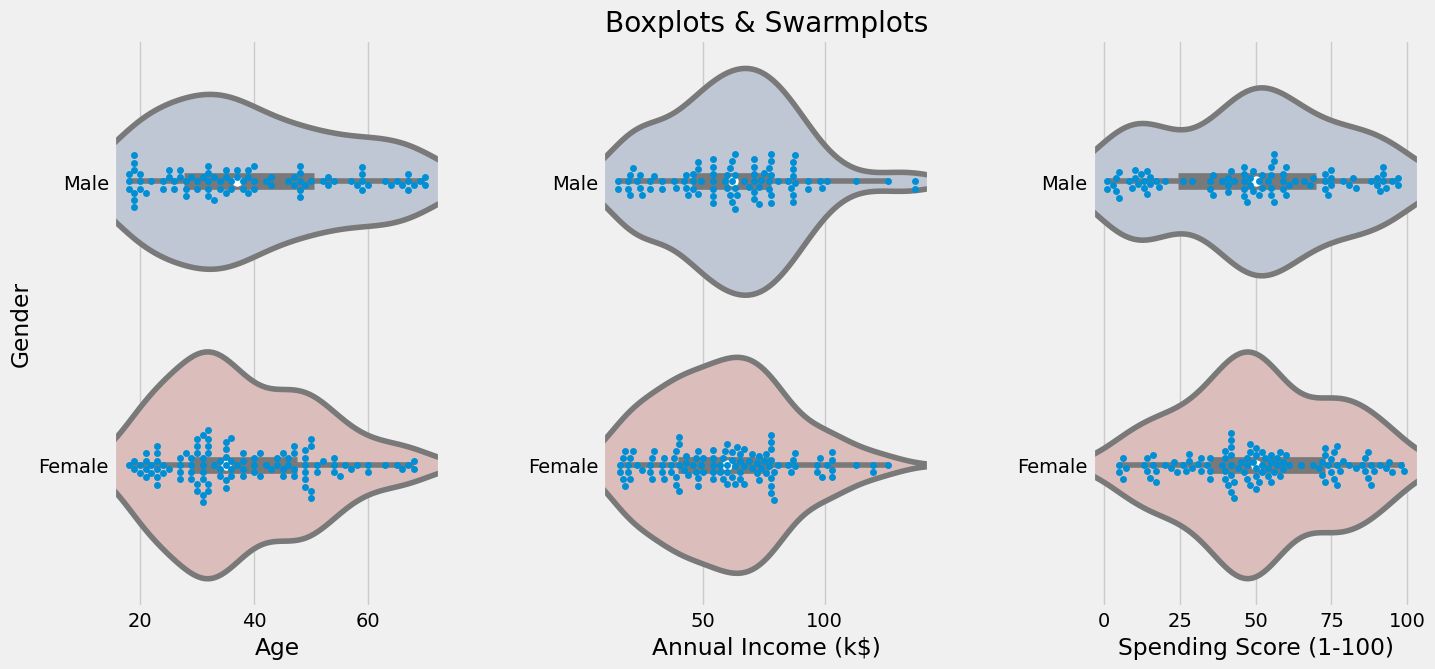

In [16]:
plt.figure(1 , figsize = (15 , 7))
n = 0 
for cols in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
    n += 1 
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    sns.violinplot(x = cols , y = 'Gender' , data = df , palette = 'vlag')
    sns.swarmplot(x = cols , y = 'Gender' , data = df)
    plt.ylabel('Gender' if n == 1 else '')
    plt.title('Boxplots & Swarmplots' if n == 2 else '')
plt.show()

In [17]:
x = df2.values

# Standardize the data
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Model Building

try it all

## Functions

In [57]:
def plot_silhouette(name, cluster_labels, x, ax=None, **kwargs):

    if ax is None:
        fig, ax = plt.subplots()

    # Compute silhouette score
    n_clusters = np.unique(cluster_labels).size
    
    silhouette_avg = silhouette_score(x, cluster_labels)    
    ax.set_title(f"{name} - Silhouette Score: {silhouette_avg:.2f}")

    # Compute silhouette values for each data point
    sample_silhouette_values = silhouette_samples(x, cluster_labels)

    y_lower = 10
    for i in range(cluster_labels.max() + 1):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.Spectral(float(i) / cluster_labels.max())
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7, **kwargs)
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax.set_xlabel("Silhouette Coefficient Values")
    ax.set_ylabel("Cluster label")
    ax.set_title(f"{name}: Clusters({cluster_labels.max() + 1}) Silhouette Score({silhouette_avg:.2f})")
    # The vertical line for the average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_xlim(-0.2, 1)

    return ax



In [19]:
def get_random_params(params):
    return {k: random.choice(v) for k, v in params.items()}

In [20]:
def scorer(algorithm, X, y=None, *args, **kwargs):    
    algorithm.fit(X)
    if hasattr(algorithm, "labels_"):
        y_pred = algorithm.labels_.astype(int)
    else:
        y_pred = algorithm.predict(X)
    silhouette_avg = silhouette_score(X, y_pred)
    return -silhouette_avg

In [21]:

def random_search(model, params, x, n_iter=10, scorer=None, cv=None, random_state=42):
    # Create a GridSearchCV object with the specified parameter grid and evaluation metric
    grid_search = RandomizedSearchCV(model, params, n_iter = n_iter, scoring=scorer, cv=cv, random_state=random_state, n_jobs=-1)

    # Fit the grid search to your data
    grid_search.fit(x)

    # Get the best hyperparameters and the best silhouette score
    best_params = grid_search.best_params_
    best_score = -grid_search.best_score_

    print("Best Hyperparameters:", best_params)
    print("Best Silhouette Score:", best_score)
    return grid_search

In [22]:

def get_cluster_centers(X, cluster_labels, n_clusters):
    centers = np.zeros((n_clusters, X.shape[1]))
    for i in range(n_clusters):
        centers[i] = np.mean(X[cluster_labels == i], axis=0)
    return centers

In [23]:
def plot_scatter_2d(x, cluster_labels, ax=None, random_state=42, **kwargs):
    n_clusters = len(np.unique(cluster_labels))
        
    if x.shape[-1] < 2:
        x = PolynomialFeatures(2).fit_transform(x)

    if x.shape[-1] != 2:
        x = TSNE(n_components=2, random_state=random_state).fit_transform(x)
        
    if ax is None:
        fig, ax = plt.subplots()
        
    if 'c' not in kwargs:
        kwargs['c'] = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

    ax.scatter(x[:, 0], x[:, 1], **kwargs)
    
    centers = get_cluster_centers(x, cluster_labels, n_clusters)
    ax.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers,1):
        ax.scatter(c[0], c[1], marker="$%d$" % i)

    return ax

In [24]:

def plot_scatter_3d(x, cluster_labels, n_clusters=None, ax=None, random_state=42,**kwargs):
    
    
    if n_clusters is None:
        n_clusters = len(np.unique(cluster_labels))

    if x.shape[-1] < 3:
        x = PolynomialFeatures(2).fit_transform(x)
        
    if x.shape[-1] != 3:
        x = TSNE(n_components=3, random_state=random_state).fit_transform(x)
        
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
    if 'c' not in kwargs:
        kwargs['c'] = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)


    ax.scatter(X[:, 0], X[:, 1], X[:, 2], **kwargs)

    centers = get_cluster_centers(X, cluster_labels, n_clusters)
    ax.scatter(
        centers[:, 0],
        centers[:, 1],
        centers[:, 2],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers, 1):
        ax.scatter(c[0], c[1], c[2], marker="$%d$" % i)

    return ax

In [74]:
def plot_datapoints(x, y, n_components=2, title=None, **kwargs):
    
    if n_components not in [2, 3]:
        raise ValueError("n_components must be in [2, 3]")
        
    if x.shape[-1] != n_components:
        x = TSNE(n_components=n_components, random_state=42).fit_transform(x)
    
    x = pd.DataFrame(x, columns=["x", "y", "z"] if n_components == 3 else ["x", "y"])
    x['cluster']=y
    x['cluster'] = x['cluster'].astype('category')
    if n_components == 2:
        fig=px.scatter(data_frame=x, x='x', y='y', color='cluster', symbol='cluster', title=title, **kwargs)
    else:
        fig=px.scatter_3d(data_frame=x, x='x', y='y', z='z', color='cluster', symbol='cluster', title=title, **kwargs)
    
    fig.show()


In [26]:
class ClusterAnalyzer:
    def __init__(self, X, range_n_clusters):
        self.X = X
        self.range_n_clusters = range_n_clusters
    
        self.default_silhouette_kwargs = {
        }
        
        self.default_scatter_kwargs = {
                "marker": ".",
                "s": 200,
                "lw": 0,
                "alpha": 0.6,
                "edgecolor": "k"
            }
   
    def analyze_clusters(self, cluster_model, name, projection='2d', silhouette_kwargs=None, scatter_kwargs=None):
        if projection not in ['2d','3d']:
            raise ValueError('Should be 2d or 3d')
            
        for n_clusters in self.range_n_clusters:
            # Create a subplot with 1 row and 2 columns
            fig = plt.figure(figsize=(8,3))
            # fig.suptitle('A tale of 2 subplots')
            
            # First subplot
            ax1 = fig.add_subplot(1, 2, 1)
            # Second subplot
            if projection=='3d':
                ax2 = fig.add_subplot(1, 2, 2, projection='3d')
            else:
                ax2 = fig.add_subplot(1, 2, 2)
                

            # The 1st subplot is the silhouette plot
            ax1.set_xlim([-0.1, 1])
            ax1.set_ylim([0, len(self.X) + (n_clusters + 1) * 10])

            # get clusters
            cluster_labels = cluster_model(self.X, n_clusters) 

            # Silhouette plot
            silhouette_kwargs = silhouette_kwargs or self.default_silhouette_kwargs
            plot_silhouette(name, cluster_labels, self.X, ax1, **silhouette_kwargs)  

            # Scatter plot
            colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
            self.default_scatter_kwargs["c"] = colors
            scatter_kwargs = scatter_kwargs or self.default_scatter_kwargs
            if projection=='2d':
                plot_scatter_2d(self.X, cluster_labels, n_clusters, ax2, **scatter_kwargs)
            else:
                plot_scatter_3d(self.X, cluster_labels, n_clusters, ax=ax2, **scatter_kwargs)
            plt.suptitle(
                f"Silhouette analysis for clustering with {n_clusters} clusters",
                # fontsize=14,
                fontweight="bold",
            )

            plt.show()
            

    def get_cluster_centers(self, cluster_labels, n_clusters):
        centers = []
        for i in range(n_clusters):
            cluster_points = self.X[cluster_labels == i]
            cluster_center = np.mean(cluster_points, axis=0)
            centers.append(cluster_center)
        return np.array(centers)


def kmeans_cluster(X, n_clusters):
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    return clusterer.fit_predict(X)

def dbscan_cluster(X, eps):
    dbscan = DBSCAN(eps=eps, min_samples=5)
    return dbscan.fit_predict(X)

def mini_batch_kmeans_cluster(X, n_clusters):
    dbscan = MiniBatchKMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, batch_size=1024, verbose=0, compute_labels=True, tol=0.0, max_no_improvement=10, n_init='warn', reassignment_ratio=0.01)
    return dbscan.fit_predict(X)

def give_a_predictor(model, params:dict)->callable:
    model = model.set_params(**params)
    def model_cluster(x, n_clusters:int)->np.ndarray:
        model.set_params(n_clusters=n_clusters)
        return model.fit_predict(x)
    return model_cluster

In [27]:
bandwidth = [estimate_bandwidth(x_scaled, quantile=quantile, n_samples=10) for quantile in np.linspace(0.35, 1.0, 10)]

In [28]:
bandwidth

[1.6327490378927465,
 2.066380931911182,
 2.066380931911182,
 2.15674589503544,
 2.426318086244577,
 2.7087152452708496,
 2.7087152452708496,
 2.925433593915991,
 3.4040782290687703,
 4.085696524791209]

In [29]:
params = {
    'ap': {
        'damping': [0.5       , 0.55444444, 0.60888889, 0.66333333, 0.71777778,
       0.77222222, 0.82666667, 0.88111111, 0.93555556, 0.99      ] ,
        'convergence_iter': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] ,
        'random_state':[random_seed],

    },
    'kmeans': {
        'n_clusters': [3, 4, 5, 6, 7, 8, 9],
        'init':['k-means++', 'random'], 
        'n_init': ['auto'],
        'tol':[0.001, 0.01, 0.1],
    },

    'meanshift':{
        'bandwidth':bandwidth,
    },
    'dbscan':{
        'eps':[0.51, 0.6, 0.7, 0.8, 0.9, 0.99],
    },
    'spectral':{
        'eigen_solver':['arpack', 'lobpcg'],
        'n_clusters': [3, 4, 5, 6, 7, 8, 9],
        'n_init':[ 5,  7,  9, 11, 13, 15, 17, 19],
        'gamma':[0.5       , 0.665, 0.831, 0.996, 1.162,
       1.327, 1.493, 1.658, 1.824, 1.99      ],
#         'affinity':['rbf', 'nearest_neighbors', 'precomputed_nearest_neighbors'],
        'n_neighbors': [ 5,  7,  9, 11, 13, 15, 17, 19],
        'random_state':[random_seed],

    },
    'agg':{
        'n_clusters': [2, 3, 4, 5, 6, 7, 8, 9],
#         'metric': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine'],
        'linkage': ['ward', 'complete', 'average', 'single'],
        'compute_distances': [True, False]
    },
    'hdbscan':{
        'min_cluster_size': [10, 15, 20], 
        'min_samples': [None, 5, 10, 15],
        'metric': ['euclidean', 'manhattan'], #, 'cosine'], 'precomputed'], 
        'alpha': [1.0, 0.5, 1.5],
        'algorithm': ['auto', 'brute', 'kdtree', 'balltree'],
        'cluster_selection_method': ['eom', 'leaf'],
    },
    'birch':{
        'threshold': [0.1, 0.3, 0.5, 0.7],
        'branching_factor': [10, 30, 50, 70],
        'n_clusters': [3, 4, 5, 6, 7, 8, 9],
    },
    'optics':{
#         'max_eps': np.linspace(0.1, 0.99, 10),
        'metric': ['cityblock', 'euclidean', 'l1', 'l2', 'manhattan'],
        'p': [1, 2, 3],
        'cluster_method': ['xi', 'dbscan'],
#         'eps': [None, 0.1, 0.5, 1.0, 2.0],
        'xi': [0.01, 0.05, 0.1, 0.2],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'leaf_size': [10, 30, 50, 100]
    },
    'gmm':{
        'n_components': [2,3,4,5,6,7,8],
        'covariance_type': ['full', 'tied', 'diag', 'spherical'],
        'tol': [1e-4, 1e-3, 1e-2, 1e-1],
        'reg_covar': [1e-7, 1e-6, 1e-5],
        'n_init': [1, 5, 10],
        'init_params': ['kmeans', 'k-means++', 'random'],
        'random_state':[random_seed],
    },
    'bgmm':{
        'n_components': [2,3,4,5,6,7,8,9,10],
        'covariance_type': ['full', 'tied', 'diag', 'spherical'],
        'tol': [1e-4, 1e-3, 1e-2, 1e-1],
        'reg_covar': [1e-7, 1e-6, 1e-5],
        'n_init': [1, 5, 10],
        'init_params': ['kmeans', 'k-means++', 'random']
    },
    'bkmeans':{
        'n_clusters': [2,3,4,5,6,7,8,9,10],
        'init': ['k-means++','random'],
        'n_init': [1, 5, 10],
        'tol': [1e-4, 1e-3, 1e-2],
        'algorithm': [ 'elkan', 'lloyd'],
        'bisecting_strategy': ['biggest_inertia', 'largest_cluster'],
    },
    'mini_batch_kmeans':{
        'n_clusters': [2,3,4,5,6,7,8,9,10],
        'init': ['k-means++','random'],
        'batch_size': [2, 4, 8, 16],
        'random_state':[random_seed],
    }
}

In [30]:
models = {
    "kmeans": KMeans(n_clusters=8, init='k-means++', n_init='warn', max_iter=300, tol=0.0001, verbose=0, random_state=42, algorithm='lloyd'),
    "ap": AffinityPropagation(),
    "meanshift": MeanShift(bandwidth=1.0, bin_seeding=False, n_jobs=-1),
    'dbscan': DBSCAN(eps=0.5, min_samples=5, metric='euclidean', algorithm='auto', leaf_size=30, n_jobs=-1),
    'spectral':cluster.SpectralClustering(n_clusters=8, gamma=1.0, affinity='rbf', n_neighbors=10, ),
    'agg': cluster.AgglomerativeClustering(n_clusters=2),
    'birch': cluster.Birch(n_clusters=8),
    'hdbscan':cluster.HDBSCAN(),
    'optics':cluster.OPTICS(),
    'gmm':mixture.GaussianMixture(),
    'bgmm':mixture.BayesianGaussianMixture(),
    'bkmeans':cluster.BisectingKMeans(),
    'mini_batch_kmeans':cluster.MiniBatchKMeans(),
}

In [31]:
get_random_params(params['kmeans'])

{'n_clusters': 4, 'init': 'random', 'n_init': 'auto', 'tol': 0.01}

In [32]:

class ClusterRandomizedSearch:
    def __init__(self, model, param_distributions, n_iter=10, scoring='silhouette_score', random_state=None):
        '''
        'Higher Calinski-Harabasz score relates to a model with better-defined clusters.'
        'Higher Silhouette score relates to a model with better-defined clusters.'
        'Lower Davies-Bouldin index relates to a model with better separation between the clusters.'
        '''
        self.model = model
        self.param_distributions = param_distributions

        if isinstance(scoring, str):
            scoring = [scoring]
        elif not isinstance(scoring, list):
            raise ValueError(f"Scoring must be a string or a list of strings. Values can be {self.get_scorer()}")

        self.scoring = scoring
        self.random_state = random_state
        self.results = []
        self.combinations = self.get_all_combinations(self.param_distributions)
        random.shuffle(self.combinations)
        self.used_combinations = set()
        self.n_iter = min(n_iter, len(self.combinations))
        self.model_name = model.__class__.__name__
        
    def fit(self, X):
        np.random.seed(self.random_state)
        for i in range(self.n_iter):
            params = self.combinations.pop()
            model = self.model.set_params(**params)
            labels = model.fit_predict(X)
            n_clusters = np.unique(labels).size
            
            all_scores = {}
            for scoring_ in self.scoring:
                score = self._evaluate_score(X, labels, scoring_)
                all_scores.update(score)
            self.results.append({'params': params, 'name': self.model_name, 'n_clusters':n_clusters, **all_scores})

        best_result = max(self.results,default=np.nan, key=lambda x: x[self.scoring[0]])
        self.best_params_ = best_result['params']
        self.best_score_ = best_result[self.scoring[0]]
        self.best_estimator_ = self.model.set_params(**self.best_params_)

    def _get_random_params(self):
        for param in self.combinations:
            yield {key: value for key, value in param.items()}

    def get_all_combinations(self, parameter_dict):
        parameter_names = list(parameter_dict.keys())
        parameter_values = list(parameter_dict.values())

        combinations = list(product(*parameter_values))
        return [{param_name: value for param_name, value in zip(parameter_names, combo)} for combo in combinations]
    
    def get_scorer(self):
            return {'silhouette_score', 'davies_bouldin_score', 'calinski_harabasz_score'}
        
    def _evaluate_score(self, X, labels, scoring):
        n_clusters = np.unique(labels).size
        
        if n_clusters == 1:
            score=np.nan
        elif scoring == 'silhouette_score':
            score = silhouette_score(X, labels)
        elif scoring == 'davies_bouldin_score':
            score = metrics.davies_bouldin_score(X, labels)
        elif scoring == 'calinski_harabasz_score':
            score = metrics.calinski_harabasz_score(X, labels)
        else:
            raise ValueError(f"Invalid scoring metric: {scoring}")

        return {scoring: score}
    
    def results_(self):        
        results_df = pd.DataFrame(self.results)
        param_columns = list(self.param_distributions.keys())
        for param_column in param_columns:
            results_df[f'param_{param_column}'] = results_df['params'].apply(lambda x: x[param_column])

        return results_df

In [33]:
scorrr = ['silhouette_score', 'davies_bouldin_score', 'calinski_harabasz_score']

In [34]:
model_grid_search = {}
n_iter=150
for i in models:
    print(i)
    tuner = ClusterRandomizedSearch(models[i], params[i], n_iter, scoring=scorrr, random_state=42)
    tuner.fit(x_scaled)

    best_params = tuner.best_params_
    best_score = tuner.best_score_
    print('Combination: ',len(tuner.get_all_combinations(params[i])))
    print('Best Parameters:', best_params)
    print('Best Score:', best_score)

    model_grid_search[i] = tuner
    print()


kmeans
Combination:  42
Best Parameters: {'n_clusters': 9, 'init': 'random', 'n_init': 'auto', 'tol': 0.01}
Best Score: 0.4025192944683836

ap
Combination:  100
Best Parameters: {'damping': 0.77222222, 'convergence_iter': 8, 'random_state': 54}
Best Score: 0.41336515636108245

meanshift
Combination:  10
Best Parameters: {'bandwidth': 2.15674589503544}
Best Score: nan

dbscan
Combination:  6
Best Parameters: {'eps': 0.9}
Best Score: 0.2543871824295203

spectral
Combination:  8960
Best Parameters: {'eigen_solver': 'lobpcg', 'n_clusters': 8, 'n_init': 5, 'gamma': 0.665, 'n_neighbors': 9, 'random_state': 54}
Best Score: 0.38517580255817535

agg
Combination:  64
Best Parameters: {'n_clusters': 9, 'linkage': 'ward', 'compute_distances': True}
Best Score: 0.39225805358687793

birch
Combination:  112
Best Parameters: {'threshold': 0.5, 'branching_factor': 70, 'n_clusters': 9}
Best Score: 0.40011959323106217

hdbscan
Combination:  576
Best Parameters: {'min_cluster_size': 10, 'min_samples': 10,

In [35]:
big_results_df = pd.DataFrame()
for model in model_grid_search:
    a = model_grid_search[model].results_()
    aa = a.sort_values('silhouette_score', ascending=False).head(3)
    print(model)
    pp = aa[['params', 'name', 'n_clusters']+scorrr]
    display(pp)
    
    big_results_df = pd.concat([big_results_df, pp])

kmeans


,params,name,n_clusters,silhouette_score,davies_bouldin_score,calinski_harabasz_score
13,"{'n_clusters': 9, 'init': 'random', 'n_init': ...",KMeans,9,0.402519,0.879571,85.816352
6,"{'n_clusters': 9, 'init': 'random', 'n_init': ...",KMeans,9,0.402519,0.879571,85.816352
10,"{'n_clusters': 9, 'init': 'random', 'n_init': ...",KMeans,9,0.402519,0.879571,85.816352


ap


,params,name,n_clusters,silhouette_score,davies_bouldin_score,calinski_harabasz_score
28,"{'damping': 0.77222222, 'convergence_iter': 10...",AffinityPropagation,16,0.413365,0.813995,91.302113
13,"{'damping': 0.88111111, 'convergence_iter': 7,...",AffinityPropagation,16,0.413365,0.813995,91.302113
70,"{'damping': 0.82666667, 'convergence_iter': 7,...",AffinityPropagation,16,0.413365,0.813995,91.302113


meanshift


,params,name,n_clusters,silhouette_score,davies_bouldin_score,calinski_harabasz_score
8,{'bandwidth': 1.6327490378927465},MeanShift,3,0.26226,1.459046,54.006704
0,{'bandwidth': 2.15674589503544},MeanShift,1,NaN,NaN,NaN
1,{'bandwidth': 2.7087152452708496},MeanShift,1,NaN,NaN,NaN


dbscan


,params,name,n_clusters,silhouette_score,davies_bouldin_score,calinski_harabasz_score
0,{'eps': 0.9},DBSCAN,3,0.254387,3.233159,34.509005
2,{'eps': 0.99},DBSCAN,3,0.254387,3.233159,34.509005
3,{'eps': 0.8},DBSCAN,6,0.172099,2.736189,28.747862


spectral


,params,name,n_clusters,silhouette_score,davies_bouldin_score,calinski_harabasz_score
9,"{'eigen_solver': 'lobpcg', 'n_clusters': 8, 'n...",SpectralClustering,8,0.385176,0.946788,79.50996
2,"{'eigen_solver': 'lobpcg', 'n_clusters': 8, 'n...",SpectralClustering,8,0.385176,0.946788,79.50996
42,"{'eigen_solver': 'lobpcg', 'n_clusters': 8, 'n...",SpectralClustering,8,0.385176,0.946788,79.50996


agg


,params,name,n_clusters,silhouette_score,davies_bouldin_score,calinski_harabasz_score
60,"{'n_clusters': 9, 'linkage': 'ward', 'compute_...",AgglomerativeClustering,9,0.392258,0.879446,81.148575
38,"{'n_clusters': 9, 'linkage': 'ward', 'compute_...",AgglomerativeClustering,9,0.392258,0.879446,81.148575
50,"{'n_clusters': 8, 'linkage': 'average', 'compu...",AgglomerativeClustering,8,0.381342,0.957413,78.185464


birch


,params,name,n_clusters,silhouette_score,davies_bouldin_score,calinski_harabasz_score
87,"{'threshold': 0.5, 'branching_factor': 70, 'n_...",Birch,9,0.40012,0.89812,81.80029
96,"{'threshold': 0.5, 'branching_factor': 50, 'n_...",Birch,9,0.40012,0.89812,81.80029
100,"{'threshold': 0.5, 'branching_factor': 30, 'n_...",Birch,9,0.40012,0.89812,81.80029


hdbscan


,params,name,n_clusters,silhouette_score,davies_bouldin_score,calinski_harabasz_score
44,"{'min_cluster_size': 10, 'min_samples': 5, 'me...",HDBSCAN,2,0.277604,1.611694,66.906291
95,"{'min_cluster_size': 20, 'min_samples': 15, 'm...",HDBSCAN,2,0.277604,1.611694,66.906291
104,"{'min_cluster_size': 20, 'min_samples': None, ...",HDBSCAN,2,0.277604,1.611694,66.906291


optics


,params,name,n_clusters,silhouette_score,davies_bouldin_score,calinski_harabasz_score
33,"{'metric': 'cityblock', 'p': 3, 'cluster_metho...",OPTICS,14,0.159597,1.440315,22.272222
143,"{'metric': 'l1', 'p': 1, 'cluster_method': 'xi...",OPTICS,14,0.159597,1.440315,22.272222
116,"{'metric': 'cityblock', 'p': 1, 'cluster_metho...",OPTICS,14,0.159597,1.440315,22.272222


gmm


,params,name,n_clusters,silhouette_score,davies_bouldin_score,calinski_harabasz_score
32,"{'n_components': 8, 'covariance_type': 'diag',...",GaussianMixture,8,0.387623,0.935209,80.827669
80,"{'n_components': 8, 'covariance_type': 'full',...",GaussianMixture,8,0.373740,0.975832,76.349232
40,"{'n_components': 8, 'covariance_type': 'full',...",GaussianMixture,8,0.366737,0.974517,74.349521


bgmm


,params,name,n_clusters,silhouette_score,davies_bouldin_score,calinski_harabasz_score
63,"{'n_components': 10, 'covariance_type': 'spher...",BayesianGaussianMixture,10,0.419617,0.825040,89.285670
38,"{'n_components': 10, 'covariance_type': 'spher...",BayesianGaussianMixture,10,0.406711,0.882735,85.346635
12,"{'n_components': 10, 'covariance_type': 'spher...",BayesianGaussianMixture,10,0.403620,0.846112,83.819204


bkmeans


,params,name,n_clusters,silhouette_score,davies_bouldin_score,calinski_harabasz_score
149,"{'n_clusters': 10, 'init': 'random', 'n_init':...",BisectingKMeans,10,0.413399,0.83269,86.726316
90,"{'n_clusters': 10, 'init': 'random', 'n_init':...",BisectingKMeans,10,0.413399,0.83269,86.726316
33,"{'n_clusters': 10, 'init': 'random', 'n_init':...",BisectingKMeans,10,0.413399,0.83269,86.726316


mini_batch_kmeans


,params,name,n_clusters,silhouette_score,davies_bouldin_score,calinski_harabasz_score
51,"{'n_clusters': 10, 'init': 'k-means++', 'batch...",MiniBatchKMeans,10,0.388289,0.889426,80.344566
25,"{'n_clusters': 9, 'init': 'random', 'batch_siz...",MiniBatchKMeans,9,0.373629,0.918951,75.315037
24,"{'n_clusters': 10, 'init': 'k-means++', 'batch...",MiniBatchKMeans,10,0.366947,1.006961,75.909053


# Big DF

In [36]:
big_results_df.sort_values(['silhouette_score', 'calinski_harabasz_score'], ascending=False).sort_values(['davies_bouldin_score', 'n_clusters'], ascending=True).head(10)

,params,name,n_clusters,silhouette_score,davies_bouldin_score,calinski_harabasz_score
28,"{'damping': 0.77222222, 'convergence_iter': 10...",AffinityPropagation,16,0.413365,0.813995,91.302113
13,"{'damping': 0.88111111, 'convergence_iter': 7,...",AffinityPropagation,16,0.413365,0.813995,91.302113
70,"{'damping': 0.82666667, 'convergence_iter': 7,...",AffinityPropagation,16,0.413365,0.813995,91.302113
63,"{'n_components': 10, 'covariance_type': 'spher...",BayesianGaussianMixture,10,0.419617,0.825040,89.285670
149,"{'n_clusters': 10, 'init': 'random', 'n_init':...",BisectingKMeans,10,0.413399,0.832690,86.726316
90,"{'n_clusters': 10, 'init': 'random', 'n_init':...",BisectingKMeans,10,0.413399,0.832690,86.726316
33,"{'n_clusters': 10, 'init': 'random', 'n_init':...",BisectingKMeans,10,0.413399,0.832690,86.726316
12,"{'n_components': 10, 'covariance_type': 'spher...",BayesianGaussianMixture,10,0.403620,0.846112,83.819204
60,"{'n_clusters': 9, 'linkage': 'ward', 'compute_...",AgglomerativeClustering,9,0.392258,0.879446,81.148575
38,"{'n_clusters': 9, 'linkage': 'ward', 'compute_...",AgglomerativeClustering,9,0.392258,0.879446,81.148575


# Fine tuned models

In [37]:
fine_tunes_models = {}

In [38]:
for name, cv in model_grid_search.items():
    fine_tunes_models[name] = cv.best_estimator_

# 2D Plots

In [39]:
len(fine_tunes_models)

13

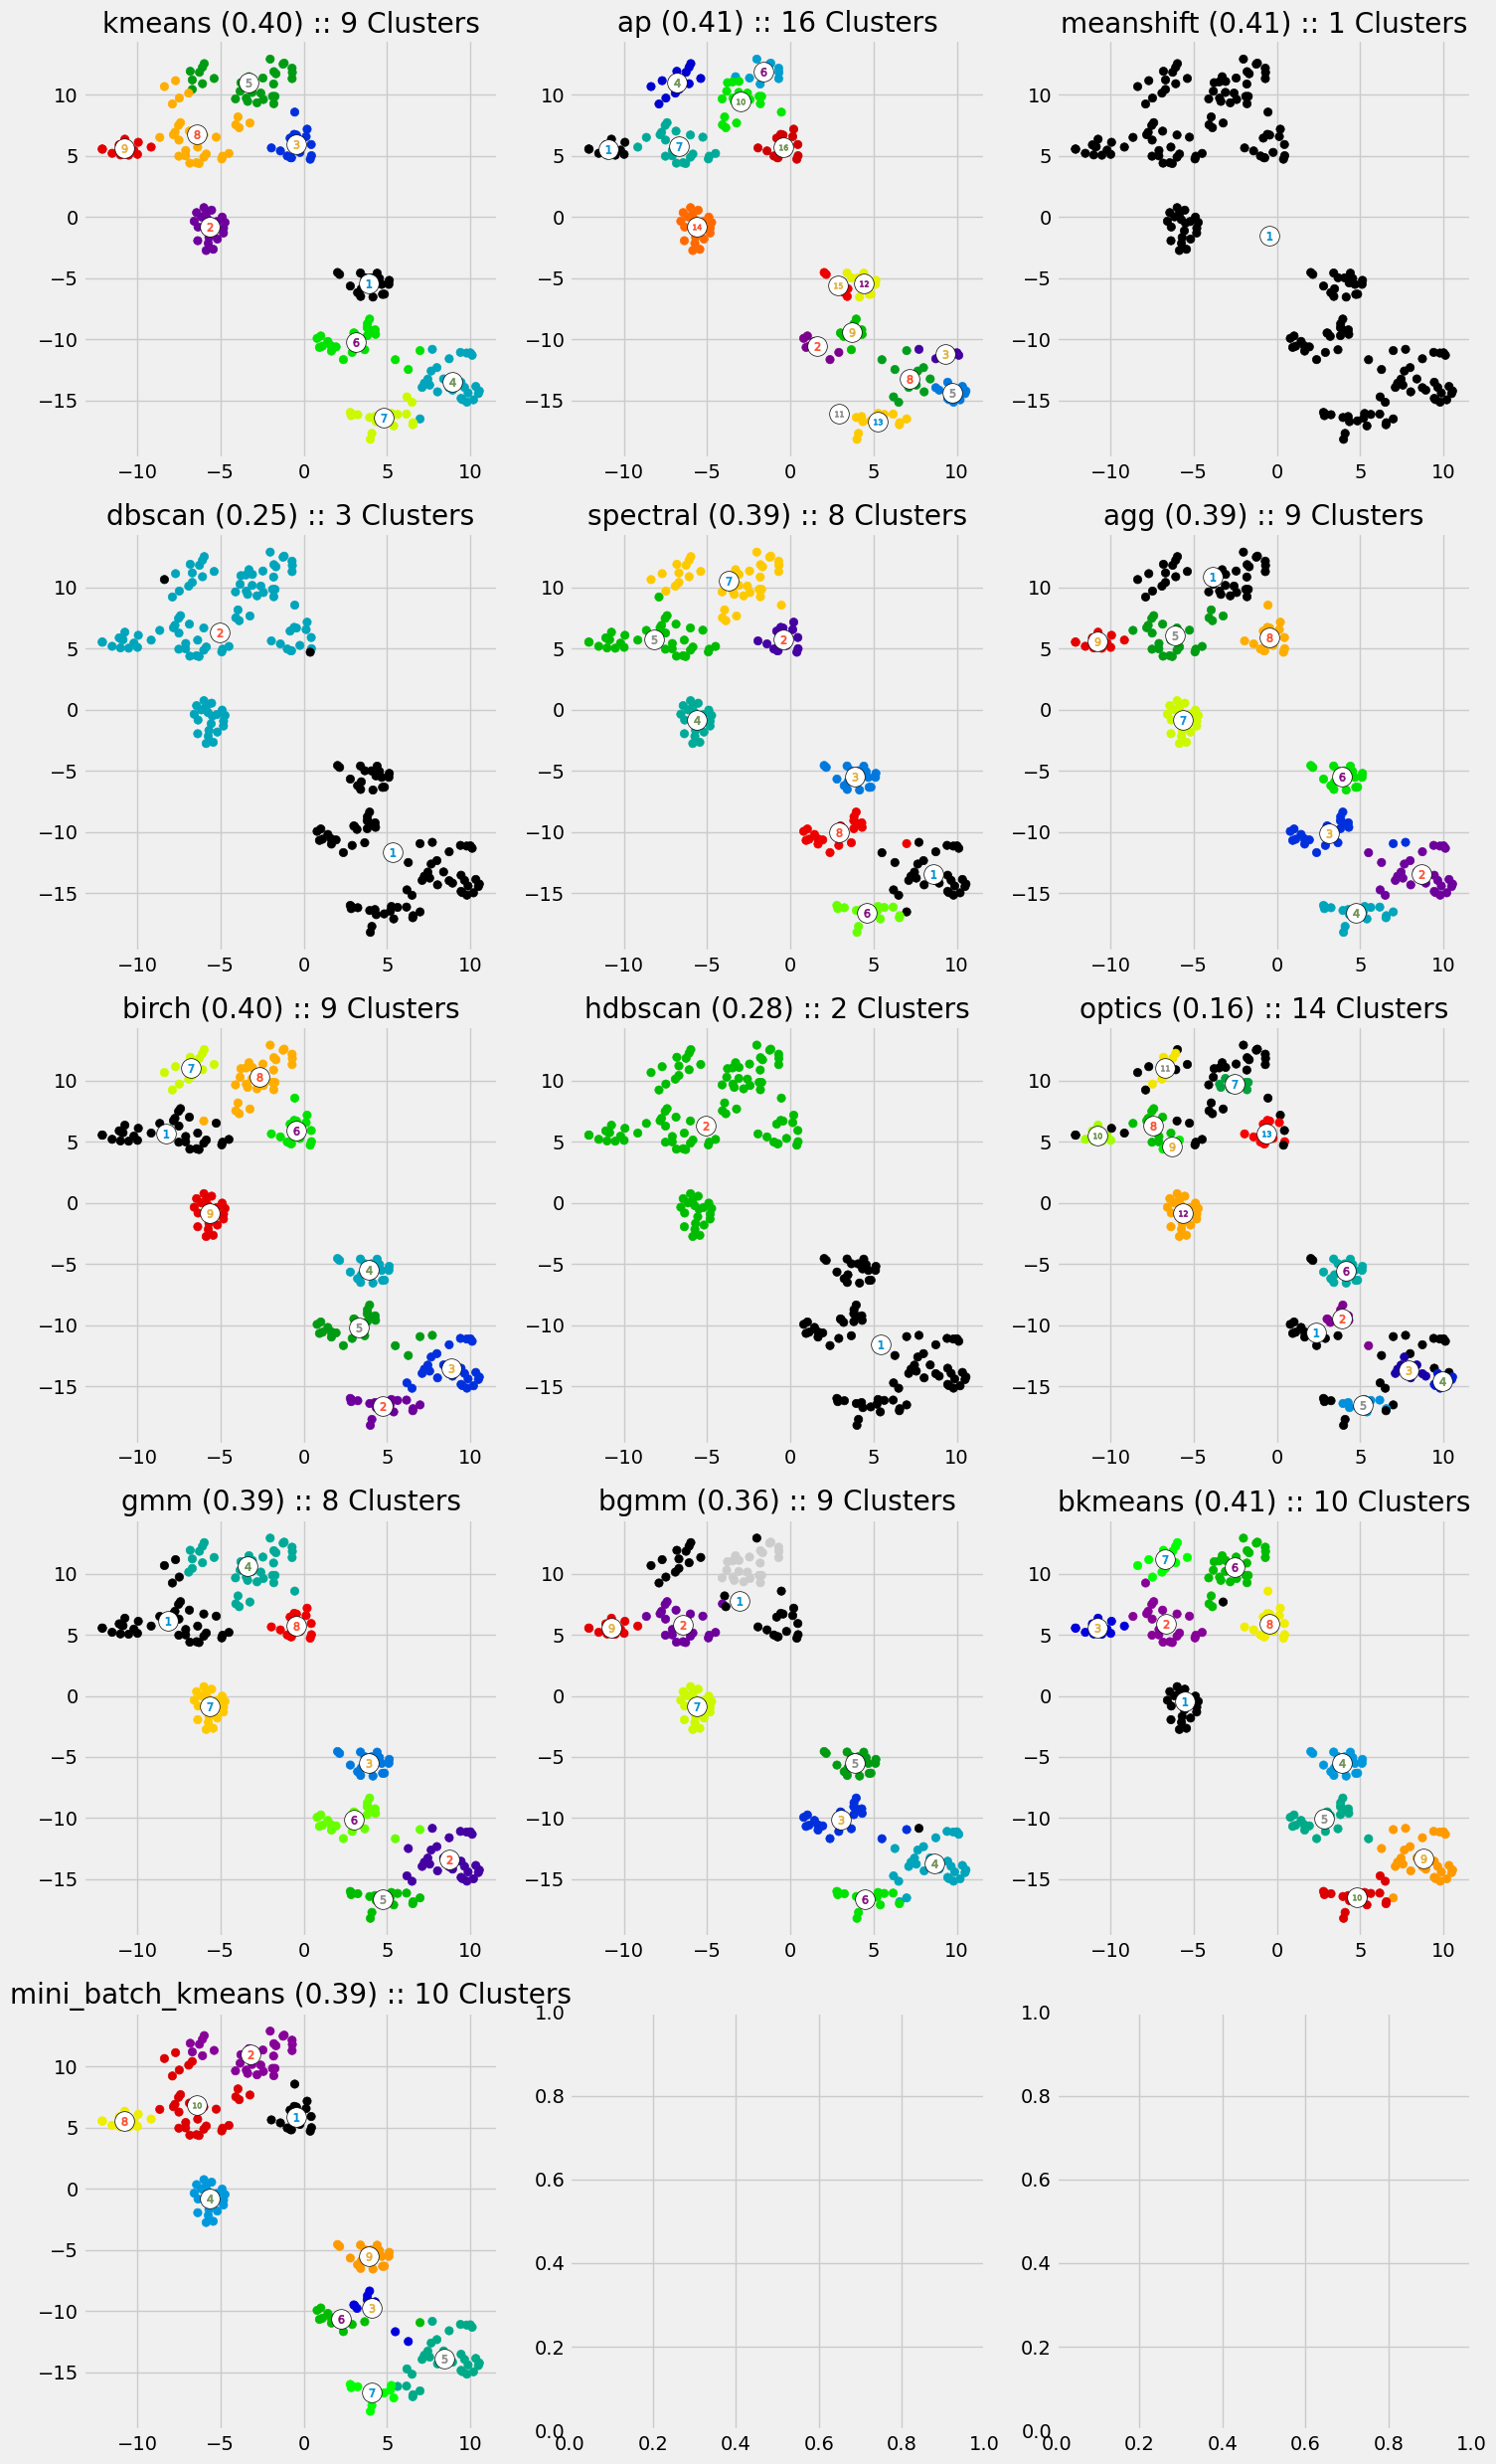

In [52]:
n_cols = 3
n_rows = (fine_tunes_models.__len__() // n_cols)+1
# Create a 4x3 grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 25))

plot_n = 0
for name, model in fine_tunes_models.items():
    model.fit(x_scaled)

    if hasattr(model, "labels_"):
        y_pred = model.labels_.astype(int)
    else:
        y_pred = model.predict(x_scaled)

    cluster_num = len(np.unique(y_pred))
    
    if cluster_num > 1:
        
        score = silhouette_score(x_scaled, y_pred)

    plot_scatter_2d(x_scaled, y_pred, ax=axes[plot_n // 3, plot_n % 3])
    axes[plot_n // 3, plot_n % 3].set_title(f'{name} ({score:.2f}) :: {cluster_num} Clusters')

    plot_n += 1

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# 3D Plots

In [42]:
nn = 1
for name, model in fine_tunes_models.items():
    model.fit(x_scaled)

    if hasattr(model, "labels_"):
        y_pred = model.labels_.astype(int)
    else:
        y_pred = model.predict(x_scaled)  # Use x_scaled, not X
    
    n_clusters = np.unique(y_pred).size
    if n_clusters > 1:
        score = silhouette_score(x_scaled, y_pred)
    plot_datapoints(x_scaled, y_pred, n_components=3, title=f'{nn}. {name}({score:.2f})::({n_clusters} Clusters)')
        
    nn += 1
#     print(nn)

Some of the Datapoints are in same cluster but in different places. It just may be because of projection in lower dimensions.

# Sihouette Plots

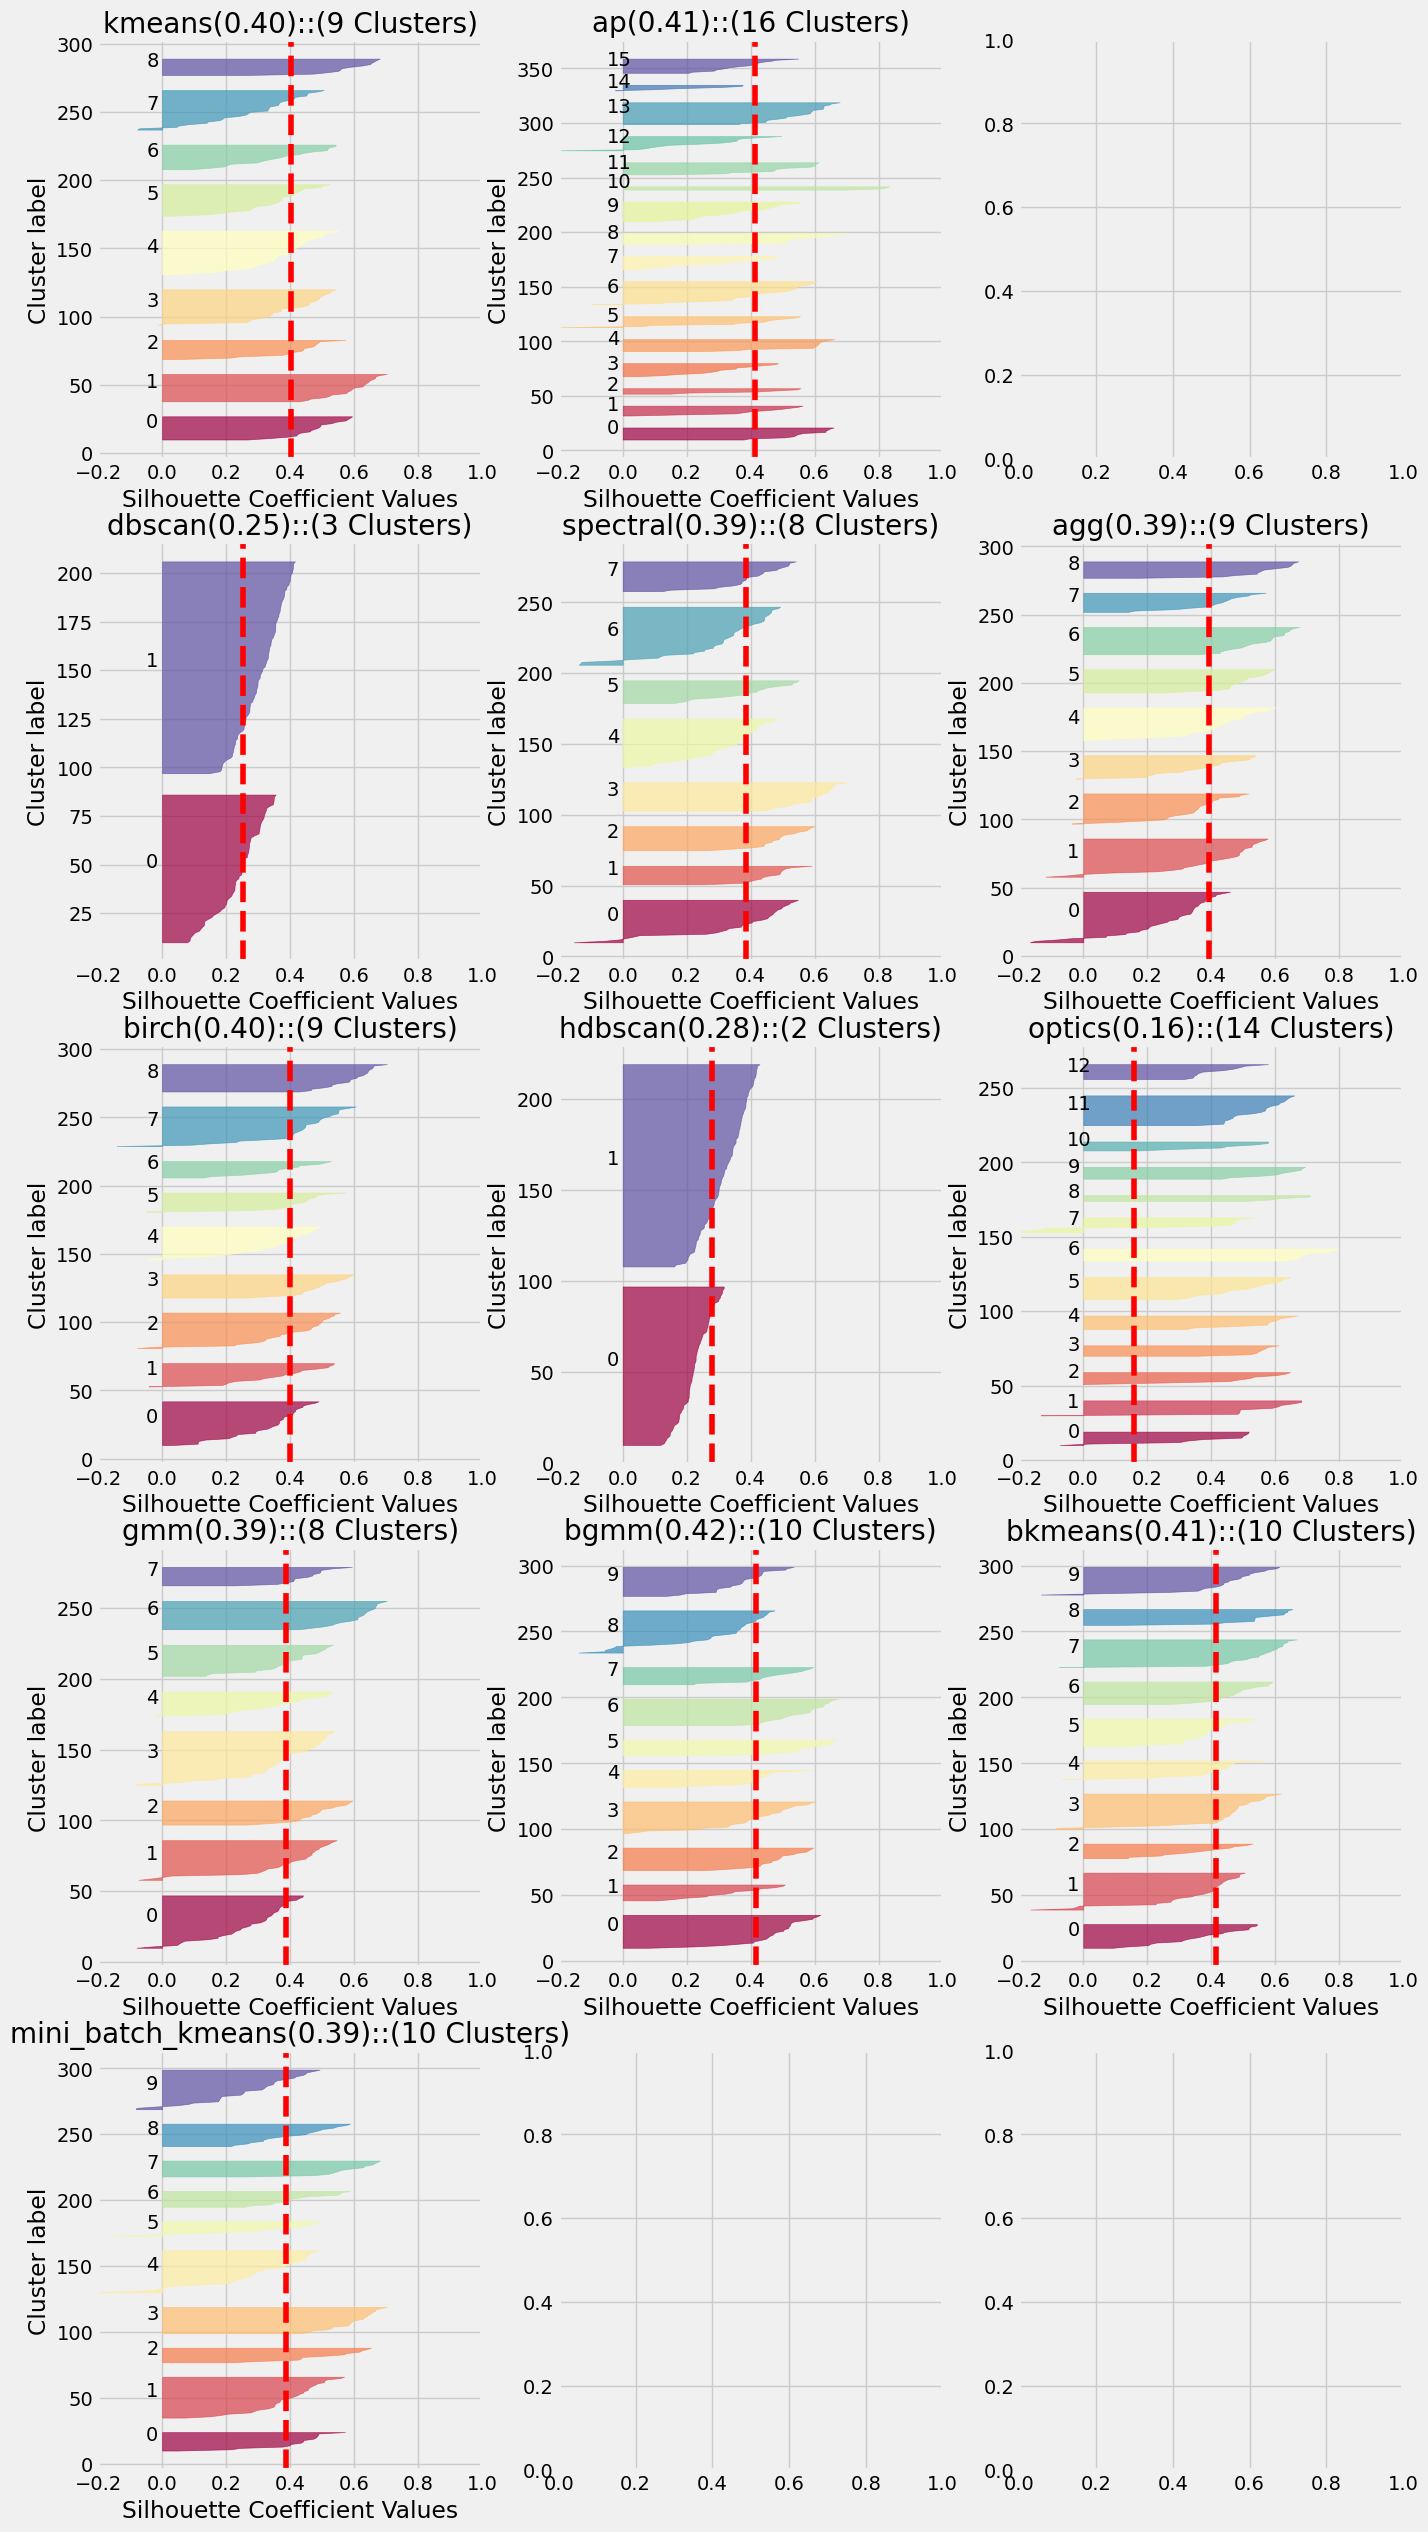

In [58]:



fig, ax = plt.subplots(n_rows, n_cols, figsize=(15, 30))

plot_n = 0
for name, model in fine_tunes_models.items():
    model.fit(x_scaled)

    if hasattr(model, "labels_"):
        y_pred = model.labels_.astype(int)
    else:
        y_pred = model.predict(x_scaled)
    
    n_clusters = len(np.unique(y_pred))
    
    score = 0
    if n_clusters > 1:
        score = silhouette_score(x_scaled, y_pred)
        plot_silhouette(name, y_pred, x_scaled, ax=ax[plot_n // 3, plot_n % 3])
        ax[plot_n // 3, plot_n % 3].set_title(f'{name}({score:.2f})::({n_clusters} Clusters)')

    plot_n += 1

plt.show()

# Conclusion

Give the Cluster plots and silhouette scores for each model the optimum number of well difined clusters is 6-10.
Any model with Silhouette score above 0.35 is considered to be a good model here.

So, 

1. Kmeans
2. BKmeans
3. Birch
4. BGMM
5. Spectral
6. Agg

Not in a Particular Order, but i like Kmeans for no reason.

# Saving the models

In [59]:
good_models = ['kmeans','bkmeans','birch','bgmm','spectral','agg']

In [60]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import pickle
from pathlib import Path

In [61]:
model_dir = Path('models')
model_dir.mkdir(exist_ok=True)

pipes  = {}
for model in good_models:
    best_one=fine_tunes_models[model]
    
    pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  
            ('scaler', StandardScaler()),  
            (model, best_one)
    ])
    pipes[model] = pipeline
    pipeline.fit(x_scaled)

    filename = model_dir/f'{model}_pipeline.pkl'
    pickle.dump(pipeline, open(filename, 'wb'))

In [62]:

a = pipes['kmeans']

In [63]:
a

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('kmeans',
                 KMeans(init='random', n_clusters=9, n_init='auto',
                        random_state=42, tol=0.01))])

In [64]:
aa = a.fit(x)

In [70]:
aa.named_steps['kmeans'].labels_

array([5, 5, 7, 8, 7, 8, 7, 8, 3, 8, 3, 8, 4, 8, 3, 5, 7, 5, 3, 8, 5, 5,
       4, 5, 4, 5, 4, 5, 4, 8, 3, 8, 3, 5, 4, 8, 4, 8, 7, 8, 4, 5, 3, 7,
       4, 8, 4, 7, 7, 7, 4, 5, 7, 3, 4, 3, 4, 3, 7, 3, 3, 5, 4, 4, 3, 5,
       4, 4, 5, 7, 3, 4, 4, 4, 3, 5, 4, 5, 7, 4, 3, 5, 3, 4, 7, 3, 4, 7,
       7, 4, 4, 5, 3, 7, 7, 5, 4, 7, 3, 5, 7, 4, 3, 5, 3, 7, 4, 3, 3, 3,
       3, 7, 7, 5, 7, 7, 4, 4, 4, 4, 5, 7, 7, 0, 7, 1, 6, 0, 3, 0, 6, 0,
       7, 1, 6, 1, 2, 0, 6, 1, 2, 0, 7, 1, 6, 0, 6, 1, 2, 0, 6, 0, 2, 1,
       2, 1, 6, 1, 6, 1, 2, 1, 6, 1, 6, 1, 6, 1, 2, 0, 6, 0, 6, 0, 2, 1,
       6, 0, 6, 0, 2, 1, 6, 1, 2, 0, 2, 0, 2, 1, 2, 1, 6, 1, 2, 1, 2, 0,
       6, 0], dtype=int32)

In [71]:
aa.named_steps['kmeans'].get_params()

{'algorithm': 'lloyd',
 'copy_x': True,
 'init': 'random',
 'max_iter': 300,
 'n_clusters': 9,
 'n_init': 'auto',
 'random_state': 42,
 'tol': 0.01,
 'verbose': 0}

In [72]:
xx_scaled = aa.named_steps['scaler'].transform(x)

In [82]:
point_names = df['CustomerID'].values.tolist()

In [83]:
plot_datapoints(xx_scaled, aa.named_steps['kmeans'].labels_, n_components=3, title='kmeans', hover_name=point_names)